In [7]:
import os
import numpy as np
import pandas as pd
import nltk
import re
!pip install contractions
import contractions
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge as R
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score as acu

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Bidirectional, Dense
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.math import rint, reduce_sum, divide, exp, subtract, greater_equal
from tensorflow.math import round as rounding
from tensorflow.random import set_seed
from tensorflow import cast, constant
from tensorflow.nn import softmax

!pip install plot-keras-history
from plot_keras_history import plot_history

from transformers import BertTokenizer, TFBertForSequenceClassification

import gensim
import gensim.downloader as api

seed = 111
np.random.seed(seed)
set_seed(seed)

import nltk
from spacy import load
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.4 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 6.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9472 sha256=cf7631b9ef8dc45f062b4ad491841f12c5432ee25a28c487688cbfafd658183b
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320514 sha256=c894c4bd7e4f4cb665bbae256c2978b60e3df1d4983a6d37012ed30a75a7b1b5
  Stored in directory: /root/.cache/pip/wheels/b7/f3/5d/748143833c99806921d4e1182c248876b83464746ef1e46f1d
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5650 sha256=11821e73e50abeef94af99b463685f5d250b7139d77256f9c35e240afa255afd
  Stored in

In [8]:
import contractions

In [9]:
#Train Data
train = pd.read_csv('../input/nlp-getting-started/train.csv')

#Test Data
test = pd.read_csv('../input/nlp-getting-started/test.csv')

#Submission
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

#Target values
y = train.target.values

In [10]:
#train = train.drop(['keyword', 'location', 'id'], axis = 1)
#test = test.drop(['keyword', 'location', 'id'], axis = 1)

In [ ]:
def text_clean_normalize(df, labeled=True, stopwords=True, lemmatize=True, dropdigits=True, dropsinLet=True, c="text"):
    #Emojis
    emojis = ["\U0001F600", "\U0001F64F", "\U0001F300", "\U0001F5FF", "\U0001F680", "\U0001F6FF", "\U0001F1E0", "\U0001F1FF", "\U00002702", "\U000027B0", "\U000024C2", "\U0001F251"]

    #Stop Words
    stopWords = nltk.corpus.stopwords.words("english")

    #Tokenizer for all word characters
    token = nltk.tokenize.RegexpTokenizer(r"\w+")

    #Lemmatizer - 
    lemmatizer = nltk.stem.WordNetLemmatizer()

    fake = []
    real = []
    data = []
    col = np.where(df.columns == c)[0][0]
    
    for i, row in enumerate(df.iterrows()):

        sentence = row[1][col]
        sentence = sentence.lower().split(" ")
        sentence = [word for word in sentence if emojis not in word and 'http' not in word and 'https' not in word and '@' not in word]
        sentence=[contractions.fix(word) for word in sentence]
        sentence=" ".join(sentence).lower()
        sentence=token.tokenize(sentence)
       
        if stopwords == True:
            sentence =[word for word in sentence if word not in stopWords]
        if lemmatize == True:
            sentence= [lemmatizer.lemmatize(word) for word in sentence]
        sentence = [word.strip() for word in sentence]
        if dropdigits == True:
            sentence = [word for word in sentence if not re.match(r"\S*\d+\S*", word)]
        sentence = [word for word in sentence if word != "rt" and word != "û_" and word != "amp" and word != "ûª" andword != "ûªs" andword != "ûò" andword != "åè" andword != "ìñ1"] 
        if dropsinLet == True:
            sentence=[word for word in sentence if len(word) > 1]
        
        if labeled == True:
            if row[1][col+1] == 1:
                fake.extend(sentence)
            else:
                real.extend(sentence)

        data.append(" ".join(sentence))
        
    return data, fake, real

In [13]:
trainn, F, T = cleaner(train)
testt, e, e = cleaner(test, labeled=False)

In [14]:
np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])

y_train_val = y[r > 0.2]
y_test_val = y[r <= 0.2]

train_val, a, a = cleaner(train.loc[r > 0.2])
test_val, a, a = cleaner(train.loc[r <= 0.2], labeled=False)

In [15]:
#Baseline: N-grams

np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_train_val = y[r > 0.2]
y_test_val = y[r <= 0.2]
train_val, a, a = cleaner(train.loc[r > 0.2])
test_val, a, a = cleaner(train.loc[r <= 0.2], labeled=False)

vectorizer = TfidfVectorizer(min_df= 2, max_df = 0.2, analyzer = 'char_wb', ngram_range = (3,7))

vectorizer.fit(train_val + test_val)
tr=vectorizer.transform(train_val)
te=vectorizer.transform(test_val)

model = R(alpha=0.2)
model.fit(train, y_train_val)

Ridge(alpha=0.2)

In [16]:
Predictions = model.predict(testt)
Predictions = np.where(Predictions >= 0.8, 1, 0)
print("Accuracy using N-Grams is:", np.round(acu(Predictions, y_test_val)*100, 2), "%!")

Accuracy using N-Grams is: 74.31 %!


In [17]:
#Tokenize/Padding:
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_train_val = y[r > 0.2]
y_test_val = y[r <= 0.2]
train_val, a, a = cleaner(train.loc[r > 0.2], stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False)
test_val, a, a = cleaner(train.loc[r <= 0.2], stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False, labeled=False)

tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(train_val)
train_val = tokenizer.texts_to_sequences(train_val)
test_val = tokenizer.texts_to_sequences(test_val)

vocabulary_size_val = len(tokenizer.index_word)+1

length_val=max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

train_val = pad_sequences(train_val, padding='post', maxlen=length_val)
test_val = pad_sequences(test_val, padding='post', maxlen=length_val)

In [18]:
#Bidirectional LSTM
def LSTM_Bidirectional(vocSize, inpShape):
    inp = Input(shape = (inpShape), name = "input")
    emb = Embedding(input_dim = vocSize,output_dim = 4)(inp)
    drop = Dropout(0.3)(emb)
    biLstm = Bidirectional(LSTM(units=16, activation='tanh',return_sequences = True,stateful=False,recurrent_dropout = 0.4,dropout=0.4))(drop)
    biLstm = Bidirectional(LSTM(units = 8,activation ='tanh',return_sequences = False,stateful = False,recurrent_dropout = 0.3,dropout = 0.3))(biLstm)
    out = Dense(units = 1, activation = "sigmoid")(biLstm)
    m = Model(inputs = inp, outputs = out)
    m.summary()
    return m

In [19]:
model = LSTM_Bidirectional(vocabulary_size_val, length_val)

optimizer = tf.keras.optimizers.legacy.Adamax(lr=0.01, decay=0.0005, clipvalue=10)

loss = BinaryCrossentropy(label_smoothing=0.01)

model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])

history = model.fit(x = train_val, y = y_train_val,validation_data = (test_val, y_test_val),epochs = 10,batch_size = 96, shuffle = True,verbose = 1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 4)             49192     
                                                                 
 dropout (Dropout)           (None, 32, 4)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 32, 32)           2688      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 17    

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


64/64 [==============================] - 17s 96ms/step - loss: 0.6598 - accuracy: 0.6008 - val_loss: 0.5654 - val_accuracy: 0.7253
Epoch 2/10
64/64 [==============================] - 5s 78ms/step - loss: 0.5295 - accuracy: 0.7547 - val_loss: 0.4970 - val_accuracy: 0.7774
Epoch 3/10
64/64 [==============================] - 5s 83ms/step - loss: 0.4611 - accuracy: 0.7940 - val_loss: 0.4538 - val_accuracy: 0.8031
Epoch 4/10
64/64 [==============================] - 5s 79ms/step - loss: 0.4277 - accuracy: 0.8145 - val_loss: 0.4433 - val_accuracy: 0.8072
Epoch 5/10
64/64 [==============================] - 5s 78ms/step - loss: 0.3978 - accuracy: 0.8329 - val_loss: 0.4455 - val_accuracy: 0.8099
Epoch 6/10
64/64 [==============================] - 5s 78ms/step - loss: 0.3770 - accuracy: 0.8476 - val_loss: 0.4425 - val_accuracy: 0.8058
Epoch 7/10
64/64 [==============================] - 5s 79ms/step - loss: 0.3540 - accuracy: 0.8546 - val_loss: 0.4546 - val_accuracy: 0.8133
Epoch 8/10
64/64 [=====

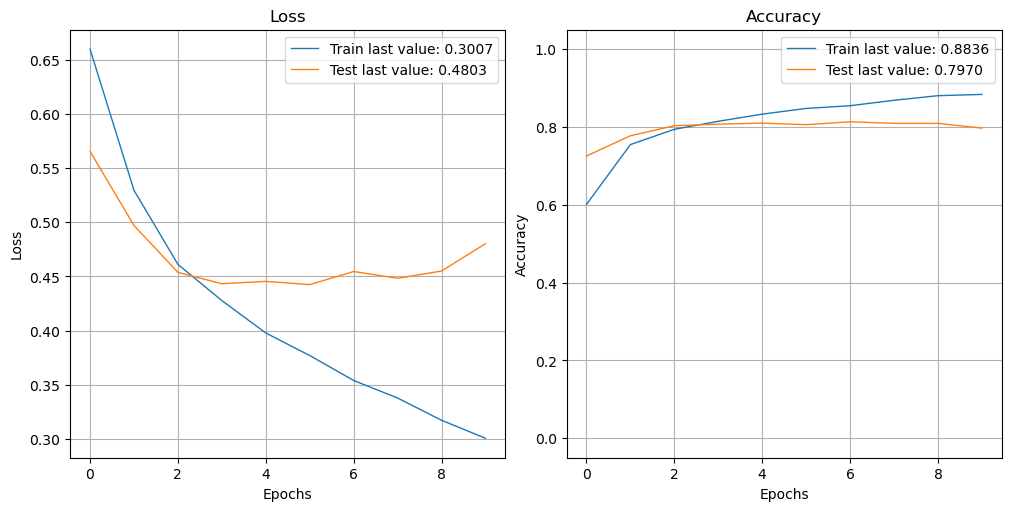

In [20]:
plot_history(history)
plt.show()

In [21]:
#Incorporating Word2Vec
#Simple Data Prep

train, F, T = cleaner(train, stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False)
test, o, o = cleaner(test, stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False, labeled=False)

r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_train_val = y[r > 0.2]
y_test_val = y[r <= 0.2]
train_val, a, a = cleaner(train.loc[r > 0.2], stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False)
test_val, a, a = cleaner(train.loc[r <= 0.2], stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False, labeled=False)

filler = [s.split(" ") for s in tr]
filler.extend([s.split(" ") for s in te])

In [22]:
#Word2Vec
w2v =  gensim.models.Word2Vec(filler, min_count=4, workers=4, window =5, sg = 1)

#Words not in test dataset but in train dataset are changed to synonyms that are in test dataset
def wordChanger(trainList, testList, minSimilar=0.5, numPrint=300):

    te_listList = [s.split(" ") for s in testList]

    tr_uniques=set(" ".join(trainList).split(" "))
    wc = 0
    try:
        for i, s in enumerate(te_listList):
            for j, w in enumerate(s):
                if w not in tr_uniques and w in w2v.wv.index_to_key and w2v.wv.most_similar(w, topn=1)[0][0] in tr_uniques \
                and w2v.wv.most_similar(w, topn=1)[0][1] >= minSimilar:
                    te_listList[i][j] = w2v.wv.most_similar(w, topn=1)[0][0]
                    wc += 1
                    if i < numPrint:
                        print(w + " changed in " + w2v.wv.most_similar(w, topn = 1)[0][0])

    except Error as e:
        print(w + " Err: " + e)

    print(str(wc) + " words changed")
    
    te_listList = [" ".join(s) for s in te_listList]
    
    return te_listList

test_val = wordChanger(train_val, test_val)

kiss changed in affects
coahuila changed in marin
coahuila changed in marin
esp changed in affects
salvation changed in member
salvation changed in member
preseason changed in sees
esp changed in affects
keeping changed in battery
higher changed in upper
higher changed in upper
48 words changed


In [23]:
#Tokenize/Padding
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(train_val)
train_val = tokenizer.texts_to_sequences(train_val)
test_val = tokenizer.texts_to_sequences(test_val)

vocabulary_size_val = len(tokenizer.index_word)+1

length_val = max([max([len(i) for i in train_val]), max([len(i) for i in test_val])])

train_val = pad_sequences(train_val, padding='post', maxlen=length_val)
test_val = pad_sequences(test_val, padding='post', maxlen=length_val)

In [24]:
#LSTM Model with Word2Vec
model = LSTM_Bidirectional(vocabulary_size_val, length_val)
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)
history = model.fit(
    x = train_val, 
    y = y_train_val,
    validation_data = (test_val, y_test_val),
    epochs = 10, 
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 32, 4)             48916     
                                                                 
 dropout_1 (Dropout)         (None, 32, 4)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 32, 32)           2688      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 17  

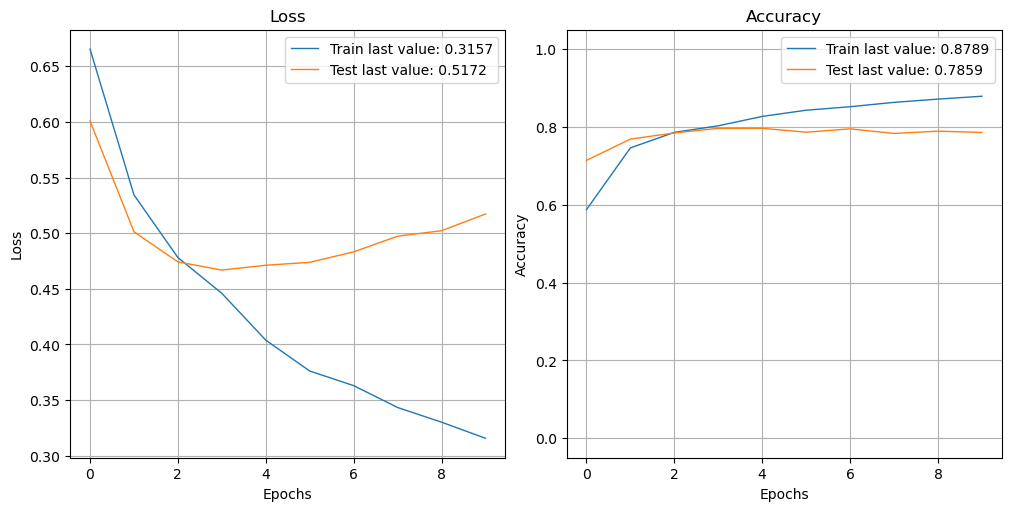

In [25]:
plot_history(history)
plt.show()

In [26]:
#BERT
    
    #Data Prep
train, F, T = cleaner(train, stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False)
test, a, a = cleaner(test, stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False, labeled = False)

r = np.random.uniform(low=0.0, high=1.0, size=train.shape[0])
y_train_val = y[r > 0.2]
y_test_val = y[r <= 0.2]
train_val, a, a = cleaner(train.loc[r > 0.2], stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False)
test_val, a, a = cleaner(train.loc[r <= 0.2], stopwords=False, lemmatize=False, dropdigits=True, dropsinlet=False, labeled = False)

In [28]:
#Bert Model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

#Bert tokenizer
def prepareBERT(l, X, Y=None):
    inp_ids = []
    am = []

    for s in X:
        bert_inp = bert_tokenizer.encode_plus(
            s,
            add_special_tokens = True,
            max_length = l,
            padding ='max_length',
            return_attention_mask = True,
            truncation = True
        )
        inp_ids.append(bert_inp['input_ids'])
        am.append(bert_inp['attention_mask'])

    inp_ids = np.asarray(inp_ids)
    am = np.array(am)
    print(len(inp_ids));print(len(am))
    if Y is not None:
        print(len(Y))
    return inp_ids, am

input_ids_te_val, attention_mask_te_val = prepareBERT(length_val, test_val, y_test_val)
input_ids_tr_val, attention_mask_tr_val = prepareBERT(length_val, train_val, y_train_val)

bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    hidden_dropout_prob = 0.15,
    attention_probs_dropout_prob = 0.15,
    hidden_act = "relu",
    num_labels = 2
)

optimizer = Adam(
    lr = 5e-5, 
    epsilon = 1e-08,
    clipvalue = 10
)

loss = SparseCategoricalCrossentropy(from_logits=True)

bert_model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = SparseCategoricalAccuracy()
)
bert_model.trainable = True
bert_model.summary()

1518
1518
1518
6095
6095
6095


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_77 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = bert_model.fit(
    [input_ids_tr_val,attention_mask_tr_val],
    y_train_val,
    batch_size = 1,
    epochs = 10,
    validation_data = ([input_ids_te_val,attention_mask_te_val],y_te_val)
)

Epoch 1/10
6095/6095 [==============================] - 10579s 2s/step - loss: 0.8821 - sparse_categorical_accuracy: 0.5089 - val_loss: 0.7257 - val_sparse_categorical_accuracy: 0.4414
Epoch 2/10
6095/6095 [==============================] - 10368s 2s/step - loss: 0.9208 - sparse_categorical_accuracy: 0.5142 - val_loss: 0.7396 - val_sparse_categorical_accuracy: 0.4414
Epoch 3/10
6095/6095 [==============================] - 10505s 2s/step - loss: 0.9181 - sparse_categorical_accuracy: 0.5176 - val_loss: 0.7290 - val_sparse_categorical_accuracy: 0.4414
Epoch 4/10
6095/6095 [==============================] - ETA: 0s - loss: 0.9373 - sparse_categorical_accuracy: 0.5175